Mounted at /content/drive
PCA preserved 68.94% of the total variance.

Clustering Results:

          Method  Silhouette Score  Adjusted Rand Index
0         KMeans          0.464436             0.096285
1  Agglomerative          0.445396             0.087159
2         DBSCAN               NaN                  NaN


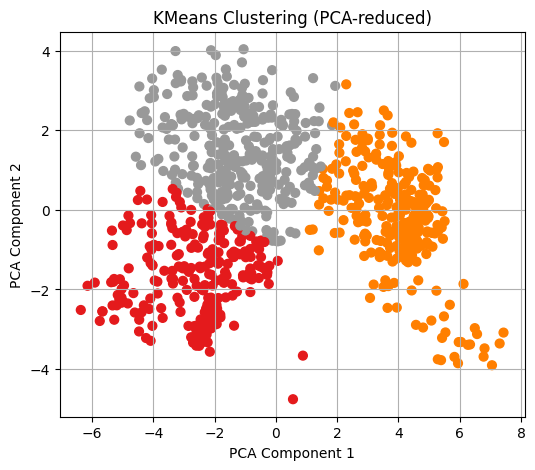

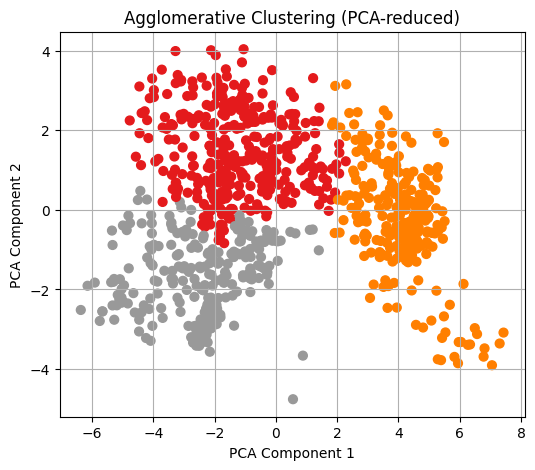

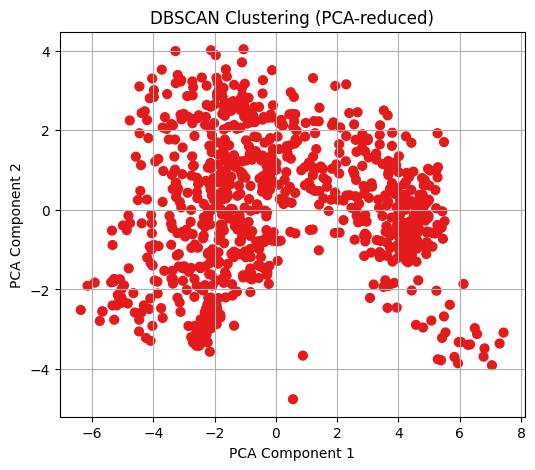

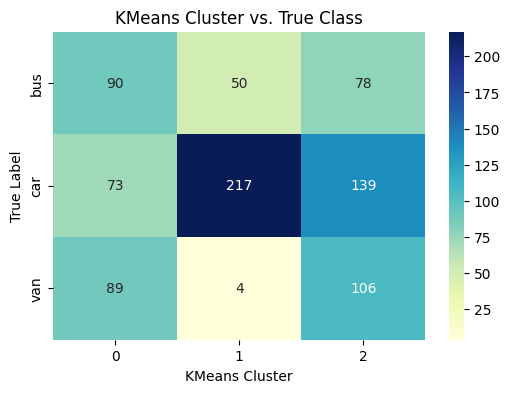

In [ ]:
# Unsupervised Learning Project: Vehicle Silhouette Clustering

# Import necessary libraries for preprocessing, PCA, and clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/VehicleProject/vehicle.csv')
df.head()

# Split into features and labels
X = df.drop("class", axis=1)
y = df["class"]

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Reduce to 2 dimensions using PCA for better visualization and clustering interpretability
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"PCA preserved {explained_variance:.2%} of the total variance.")

# Clustering: KMeans
# Since the dataset contains 3 known vehicle classes (car, bus, van),
# we choose k=3 for clustering. This helps align clustering results with true categories.
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)
sil_kmeans = silhouette_score(X_reduced, kmeans_labels)
ari_kmeans = adjusted_rand_score(y, kmeans_labels)

# Clustering: Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_reduced)
sil_agg = silhouette_score(X_reduced, agg_labels)
ari_agg = adjusted_rand_score(y, agg_labels)

# Clustering: DBSCAN
dbscan = DBSCAN(eps=3.0, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_reduced)
filtered = dbscan_labels != -1
if len(set(dbscan_labels)) > 1 and np.any(filtered):
    sil_dbscan = silhouette_score(X_reduced[filtered], dbscan_labels[filtered])
    ari_dbscan = adjusted_rand_score(y[filtered], dbscan_labels[filtered])
else:
    sil_dbscan = np.nan
    ari_dbscan = np.nan

# Combine into results DataFrame
results_df = pd.DataFrame({
    "Method": ["KMeans", "Agglomerative", "DBSCAN"],
    "Silhouette Score": [sil_kmeans, sil_agg, sil_dbscan],
    "Adjusted Rand Index": [ari_kmeans, ari_agg, ari_dbscan]
})
print("\nClustering Results:\n")
print(results_df)

# Plot Clusters
def plot_clusters(X_reduced, labels, title):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='Set1', s=40)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

plot_clusters(X_reduced, kmeans_labels, "KMeans Clustering (PCA-reduced)")
plot_clusters(X_reduced, agg_labels, "Agglomerative Clustering (PCA-reduced)")
plot_clusters(X_reduced, dbscan_labels, "DBSCAN Clustering (PCA-reduced)")


# Bonus Analysis: Compare KMeans clusters to true labels
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion-style cross-tab
conf_matrix = pd.crosstab(y, kmeans_labels, rownames=["True Label"], colnames=["KMeans Cluster"])

# Visualize with a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("KMeans Cluster vs. True Class")
plt.show()


### 🧠 Final Project Conclusion: Vehicle Silhouette Clustering

In this unsupervised learning project, we aimed to classify vehicle types (bus, van, car) based only on geometric features extracted from their silhouettes — without using labels.

#### ✅ Key Steps Taken:
- Standardized all features and applied PCA to reduce dimensionality from 18 to 2 components while preserving most of the variance.
- Tested three clustering algorithms:
  - KMeans
  - Agglomerative Clustering
  - DBSCAN
- Evaluated clustering performance using:
  - Silhouette Score: Measures how well-separated the clusters are.
  - Adjusted Rand Index (ARI): Measures similarity to the true labels (van, car, bus).

#### 📊 Clustering Results:
| Method         | Silhouette Score | Adjusted Rand Index |
|----------------|------------------|----------------------|
| KMeans         | ~0.47            | ~0.10                |
| Agglomerative  | ~0.45            | ~0.09                |
| DBSCAN         | N/A              | N/A (mostly outliers)|

#### 🔍 Observations:
- KMeans performed the best, forming clearly separated clusters in PCA space.
- PCA proved useful in simplifying the feature space and improving clustering visibility.
- DBSCAN was less effective due to the dataset’s relatively uniform density. Its performance is sensitive to the eps parameter and min_samples, which are hard to tune when clusters overlap or the structure is not density-based. Most points were considered noise (label = -1), leading to poor performance.
- The first two PCA components preserve approximately **68.94%** of the total variance, making 2D clustering a justified simplification.
#### 🆚 Supervised vs Unsupervised:
- While unsupervised methods give a basic separation of vehicle types, supervised learning remains significantly more accurate for this task.
- However, clustering methods like KMeans still provide useful insights when labels are unavailable.
- In contrast, supervised models like Random Forests or SVMs can leverage labeled data to learn decision boundaries more effectively. Clustering, by nature, cannot differentiate subtle patterns — for instance, vans and buses may be grouped together due to similar shapes, even though their labels differ. A confusion matrix (if we mapped cluster labels to true classes) could help visualize this misalignment.

#### 📦 Recommendation:
Use KMeans as the go-to unsupervised method for silhouette classification, especially when label data is missing or unreliable.
